In [1]:
%pylab inline
import scipy
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


One way to characterize a classifier is by looking at the ROC curve. But first, we need to set up the problem. Because we're going to be lazy data scientists today, we're only going to look at binary classification. That is, we want to take examples and assign a label to them. The label is going to be either 0 or 1. Specifically, our classifier will take a data point $\mathbf{x}$ and return a probability $P(\mathbf{x})$ that the particular example belongs to class 1. Both the feature vectors $\mathbf{x}$ and the class labels 0 and 1 can correspond to anything. $\mathbf{x}$ may represent everything we know about a visitor to our website, and the classes 0 and 1 correspond to whether the user clicks on a certain link. On the other hand, $\mathbf{x}$ could encode medical information abut a patient, and the class labels map to the absence or presence of a certain disease.

But in addition to the probability, we also need a decison rule! At the end of the day, we will need to actually sort our examples into class 1 or class 0. For this, we'll set a threshold $p$ such that whenever $P(\mathbf{x}) > p$, we will predict $\mathbf{x} \rightarrow 1$--i.e. that $\mathbf{x}$ belongs to class 1.

By way of example, here's some histograms. We haven't made an actual classifier here, but let's pretend we did. On the x-axis is the probability assigned by our classifier to each example. The y-axis is just the number of counts in each probability bin. In this case, there are 100 probability bins each encompassing a 1% probability range. The negative examples--examples which are in reality of class 0, are drawn in blue. The positive examples--in reality class 1--are in orange. Also--I've chosen the classes to have different sizes. There are only 20 examples of class 1, whereas there are 100 examples of class 0.

In **example 1**, classifier isn't perfect. It assigns non-zero probability of being class 1 to the negative examples, and non-unity probability of being class 1 to the positive examples. The classifier, is, however, well separated. The positive and negative examples don't overlap.

On the other hand, it will often be the case that our classifier doesn't separate true positives and true negatives nearly this well. For instance, if class 1 corresponds to whether a user clicks on a web page, the distribution might look closer to **example 2**.

**Example 3** represents the case of random chance. The classifier randomly assigns a uniform probability in the range (0,1) to every example it sees. This is probably not a very useful classifier.

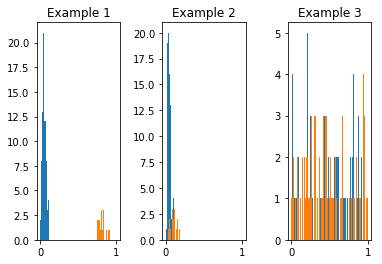

In [108]:
ex1 = [np.random.binomial(100, 0.05, size = 100)/100, np.random.binomial(100, 0.8, size = 20)/100]
ex2 = [np.random.binomial(100, 0.05, size = 100)/100, np.random.binomial(100, 0.1, size = 20)/100]
ex3 = [np.random.uniform(size = 100), np.random.uniform(size = 100)]
bins = np.linspace(0,1,100)

f, ax = plt.subplots(1, 3, sharex= True)
plt.subplots_adjust(wspace=0.5)

z=ax[0].hist(ex1[0], bins = bins)
z=ax[0].hist(ex1[1], bins = bins)
ax[0].set_title('Example 1')

z=ax[1].hist(ex2[0], bins = bins)
z=ax[1].hist(ex2[1], bins = bins)
ax[1].set_title('Example 2')

z=ax[2].hist(ex3[0], bins = bins)
z=ax[2].hist(ex3[1], bins = bins)
ax[2].set_title('Example 3')

Keep in mind what we're looking at here. The blue data represent the probabilities to click *assigned by the classifier* to users who *in actuality* did not click. The orange histogram reprents the probablities to click assigned by the classifier to users who actually did click. Even for users who do actually click, it probably makes sense to assign a small click probability because the click rates are very small overall.

What happens if we apply a threshold to the output of our calibrator?

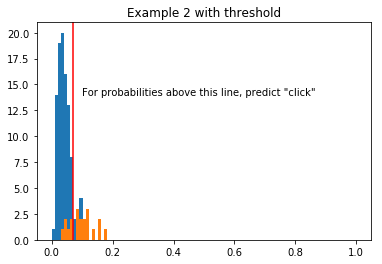

In [109]:
threshold = 0.07
z = plt.hist(ex2[0], bins = bins)
z = plt.hist(ex2[1], bins = bins)
plt.axvline(x=threshold, color='r')
plt.title('Example 2 with threshold')
plt.annotate('For probabilities above this line, predict "click"', xy=(0.1,14))

If we apply the threshold $p = 0.07$ in the above example, we will get some true positives and some false positives. The true positives are the events in which we predicted "click" and "click" actually ocurred. False positives are the events in which we predicted "click," but alas, a click did not occur. The *true positive rate* or TPR, is the fraction of positive events which are correctly labeled "click." The false positive rate, or FPR, is the fraction of negative events which are labeled "click." Naturally, both the TPR and FPR are functions of the the threshold. For the threshold chosen above, we get a TPR of 0.7, and a FPR of 0.09.

In [110]:
def tpr_fpr(data, p):
    negative_events = data[0] # the "click" probabilities assigned to events in which no click ocurred
    positive_events = data[1] # click probabilities assigned to events in which click in fact ocurred
    
    N_negative = float(len(negative_events)) # number of negative events
    N_positive = float(len(positive_events)) # number of positive events
    
    tpr = len(np.where(positive_events > p)[0])/N_positive
    fpr = len(np.where(negative_events > p)[0])/N_negative
    
    return tpr, fpr
    
tpr, fpr = tpr_fpr(ex2, 0.07)
print("TPR: {}, FPR: {}".format(tpr, fpr))

TPR: 0.7, FPR: 0.09


Let's vary the threshold and see what happens.

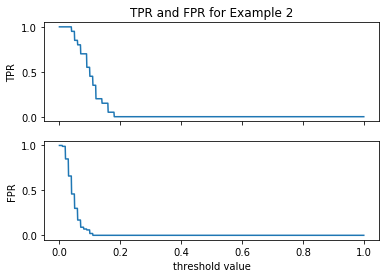

In [111]:
p_tr = np.linspace(0, 1, 1000) # thresholds to sample

data_out = np.zeros((1000, 2)) # empty array for storing the outputs

for i, p in enumerate(p_tr):
    tpr, fpr = tpr_fpr(ex2, p)
    data_out[i] = tpr, fpr

f, ax = plt.subplots(2, sharex = True)
ax[0].plot(p_tr, data_out[:,0])
ax[0].set_ylabel('TPR')
ax[1].plot(p_tr, data_out[:,1])
ax[1].set_ylabel('FPR')
ax[1].set_xlabel('threshold value')
ax[0].set_title('TPR and FPR for Example 2')

A couple things to notice here. When the threshold is zero, both the TPR and FPR are 1. This is generally true. Likewise, when the threshold is one, TPR = FPR = 1. Perhaps take a second to convince yourself that this should more or less always be true.

It is typical to plot the TPR and FPR against each other, giving what is known as the receiver operating characteristic, or ROC, curve.

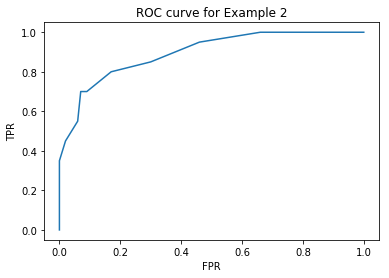

In [113]:
plt.plot(data_out[:,1],data_out[:,0])
plt.title('ROC curve for Example 2')
plt.xlabel('FPR')
plt.ylabel('TPR')

By contrast, let's look at ROC curves for the other examples.

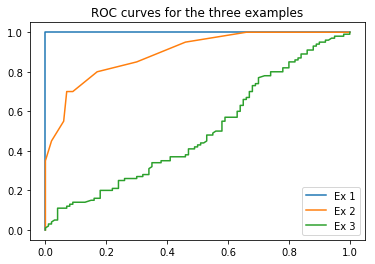

In [122]:
p_tr = np.linspace(0, 1, 1000) # thresholds to sample

data_out_1 = np.zeros((1000, 2)) # empty array for storing the outputs
data_out_2 = np.zeros((1000, 2))
data_out_3 = np.zeros((1000, 2))

for i, p in enumerate(p_tr):
    tpr, fpr = tpr_fpr(ex1, p)
    data_out_1[i] = tpr, fpr
    
    tpr, fpr = tpr_fpr(ex2, p)
    data_out_2[i] = tpr, fpr
    
    tpr, fpr = tpr_fpr(ex3, p)
    data_out_3[i] = tpr, fpr

plt.plot(data_out_1[:,1],data_out_1[:,0], label = 'Ex 1')
plt.plot(data_out_2[:,1],data_out_2[:,0], label = 'Ex 2')
plt.plot(data_out_3[:,1],data_out_3[:,0], label = 'Ex 3')
plt.legend()
plt.title('ROC curves for the three examples')

In example 1, the integral (or AUC) of the ROC curve is 1--correspondingly, the positive and negative examples are perfectly separated. In the case of of Example 3, the AUC is about 0.5--with enough data the ROC curve should approach a straight line. The AUC for Ex. 2 is somewhere between 1 and 0.5.

The AUC tells us about the *overlap* between the distributions of probabilities assigned by actual negative examples and actual positive examples. Put another way, the AUC gets a bit lower every time an actual negative example is assigned a higher probability than an actual positive example. In this sense, if we think of the output probabilities from the classifier as scores, the AUC is maximized whenever the scores are correctly ordered.

A couple of (potentially) nice facts about the AUC measure:

1. Because the TPR and FPR are normalized, class size imbalance doesn't matter for the AUC score. Thus, the AUC can be a better metric than simple "accuracy" if the class sizes are very imbalanced. For example, in Ex. 2 a classifier would have an accuracy of 80% simply by always predicting "no click."

2. Calibration also doesn't matter for the AUC score. A classifier can have a very high AUC score even if the output probabilities are not well calibrated to reality. For instance, if all positive examples are given probability 0.5, and all negative examples are given probability 0.25, the AUC will be 1 even though the output probabilities themselvse should be 0 and 1.